# CS 452/552 Data Science with Python: Homework 1

Download data files from LMS. Code/Explain your solution over this `IPython` notebook at required cells, and complete locally.

To submit your assignment, in LMS, upload your solution to LMS as a single notebook with following file name format:

`lastName_firstName_CourseNumber_HW1.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 452 or CS 552).

Problems on homework assignments are equally weighted.

Any type of plagiarism will not be tolerated. Your submitted codes will be compared with other submissions and also the codes available on internet and violations will have a penalty of -100 points. (In case of copying from
another student both parties will get -100)

Import libraries

In [2]:
#Import libraries before starting
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from bs4 import BeautifulSoup
import logging
import requests
import csv
import re
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## Problem 1: Downloading Function Definitions from Pandas

Download Binary operator functions from pandas documentation https://pandas.pydata.org/docs/reference/frame.html.

Write a Python code to write each binary operator function with corresponding definition to a tab-seperated csv file named "output.csv". For instance, a sample row will be:

DataFrame.add(other[, axis, level, fill_value])\tGet Addition of dataframe and other, element-wise (binary operator add).

**Solution:**

In [ ]:
def get_binary_operators():
    url = 'https://pandas.pydata.org/docs/reference/frame.html'
    
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Failed to retrieve the webpage. Status code: {response.status_code}")
        return []
    
    soup = BeautifulSoup(response.content, 'html.parser')

    tables = soup.find_all('table', class_='longtable')
    
    if not tables or len(tables) < 4:
        print(f"Not enough tables found. Found {len(tables)} tables.")
        return []
    
    binary_ops_table = tables[5] # binary operator table is the 5th table 
    
    if not binary_ops_table:
        print("Binary operators section not found.")
        return []
    
    binary_ops = []
    
    rows = binary_ops_table.find_all('tr')
    for row in rows:
        cells = row.find_all('td')
        if len(cells) >= 2:
            function_cell = cells[0]
            
            function_signature = function_cell.text.strip()
            
            if function_signature and not function_signature.startswith('DataFrame.'):
                function_signature = f"DataFrame.{function_signature}"
            
            description_cell = cells[1]
            description = description_cell.text.strip()
            
            if function_signature and description:
                binary_ops.append((function_signature, description))
    
    return binary_ops

In [56]:
binary_ops = get_binary_operators()

In [57]:
def write_to_csv(binary_ops, filename='output.csv'):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        for func, definition in binary_ops:
            writer.writerow([func, definition])
    print(f"CSV file '{filename}' has been created successfully.")

In [58]:
write_to_csv(binary_ops)

CSV file 'output.csv' has been created successfully.


In [59]:
output = pd.read_csv('output.csv')
print(output.head())

                                      DataFrame.__add__(other)\tGet Addition of DataFrame and other  \
DataFrame.add(other[      axis  level   fill_value])\tGet Addition of dataframe and o...              
DataFrame.sub(other[      axis  level   fill_value])\tGet Subtraction of dataframe an...              
DataFrame.mul(other[      axis  level   fill_value])\tGet Multiplication of dataframe...              
DataFrame.div(other[      axis  level   fill_value])\tGet Floating division of datafr...              
DataFrame.truediv(other[  axis  level   ...])\tGet Floating division of dataframe and...              

                                                                   column-wise.  
DataFrame.add(other[      axis  level       element-wise (binary operator add).  
DataFrame.sub(other[      axis  level       element-wise (binary operator sub).  
DataFrame.mul(other[      axis  level       element-wise (binary operator mul).  
DataFrame.div(other[      axis  level   element-wise 

## Problem 2: Handling Missing Time-Series Data

In this problem, we will be handling the problem of time-series datasets with missing values. Clearly, we cannot simply remove entire rows or columns that contain missing values. Here, we will use kNN algorithm to fill out missing stock prices over time for all Russell 1000 index constituent tickers. You can obtain the stock price data by Yahoo Finance library (yfinance) between 1/1/2018-31/12/2023. You should write a code to download Russell 1000 constituents from https://en.wikipedia.org/wiki/Russell_1000_Index. We will be using Adjusted Close Price, which is stored in "Adj Close" column. If a ticker does not have any data during this time period on Yahoo Finance, you can ignore that ticker.

We will be running our imputer method on distinct k's, ranging from 2 to 8. In this case, you may use an existing library such as ``sklearn`` for imputation.

**Solution:**

In [76]:
def get_russell1000_tickers():
    print("Downloading Russell 1000...")
    url = "https://en.wikipedia.org/wiki/Russell_1000_Index"
    tables = pd.read_html(url)
    
    constituents_df = None
    for table in tables:
        if 'Symbol' in table.columns:
            constituents_df = table
            break
    
    if constituents_df is None:
        raise ValueError("Could not find Russell 1000 table on Wikipedia")
    
    tickers = constituents_df['Symbol'].tolist()
    print(f"Some of the tickers: {tickers[:5]}")
    return tickers

In [77]:
raw_tickers = get_russell1000_tickers()
print(f"Retrieved {len(raw_tickers)} Russell 1000")

Some of the tickers: ['TXG', 'MMM', 'AOS', 'AAON', 'ABT']
Retrieved 1006 Russell 1000


In [78]:
def append_tickers(tickers): # append all tickers as a stock for correctly download the data
    all_tickers = []
    for ticker in tickers:
        all_tickers.append(ticker.strip()) 
    print(all_tickers)
    print(len(all_tickers))
    return all_tickers

In [79]:
stocks = append_tickers(raw_tickers)

['TXG', 'MMM', 'AOS', 'AAON', 'ABT', 'ABBV', 'ACHC', 'ACN', 'AYI', 'ADBE', 'ADT', 'AAP', 'WMS', 'AMD', 'ACM', 'AES', 'AMG', 'AFRM', 'AFL', 'AGCO', 'A', 'ADC', 'AGNC', 'AL', 'APD', 'ABNB', 'AKAM', 'ALK', 'ALB', 'ACI', 'AA', 'ARE', 'ALGN', 'ALLE', 'ALGM', 'LNT', 'ALSN', 'ALL', 'ALLY', 'ALNY', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'DOX', 'AMED', 'AMTM', 'AS', 'AEE', 'AAL', 'AEP', 'AXP', 'AFG', 'AMH', 'AIG', 'AMT', 'AWK', 'COLD', 'AMP', 'AME', 'AMGN', 'AMKR', 'APH', 'ADI', 'NLY', 'ANSS', 'AM', 'AR', 'AON', 'APA', 'APG', 'APLS', 'APO', 'APPF', 'AAPL', 'AMAT', 'APP', 'ATR', 'APTV', 'ARMK', 'ACGL', 'ADM', 'ARES', 'ANET', 'AWI', 'ARW', 'AJG', 'ASH', 'AZPN', 'AIZ', 'AGO', 'ALAB', 'T', 'ATI', 'TEAM', 'ATO', 'ADSK', 'ADP', 'AN', 'AZO', 'AVB', 'AVTR', 'AVY', 'CAR', 'AVT', 'AXTA', 'AXS', 'AXON', 'AZEK', 'AZTA', 'BKR', 'BALL', 'BAC', 'OZK', 'BBWI', 'BAX', 'BDX', 'BRBR', 'BSY', 'BRK.B', 'BERY', 'BBY', 'BILL', 'BIO', 'TECH', 'BIIB', 'BMRN', 'BIRK', 'BJ', 'BLK', 'BX', 'HRB', 'XYZ', 'OWL', 'BK', 'BA', 

In [12]:
start_date = '2018-01-01'
end_date = '2023-12-31'
adj_close_prices = yf.download(stocks,start=start_date, end=end_date)['Close']

[*********************100%***********************]  1006 of 1006 completed

195 Failed downloads:
['HEI.A', 'CWEN.A', 'BF.A', 'BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['SEG', 'INGM', 'ALAB', 'AS', 'MRP', 'SW', 'GRAL', 'SNDK', 'AMTM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1703998800")')
['UHAL.B', 'BF.B', 'LEN.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2023-12-31)')
['CFG', 'UDR', 'TRIP', 'DJT', 'GD', 'ASH', 'GLOB', 'THG', 'ROL', 'CCCS', 'FCN', 'INSP', 'LLY', 'EPR', 'ITT', 'XOM', 'PB', 'UPS', 'CACI', 'GILD', 'CASY', 'HBAN', 'MMM', 'TKO', 'JAZZ', 'CSL', 'AVTR', 'HEI', 'AEE', 'BJ', 'GIS', 'HUBB', 'LINE', 'PVH', 'PATH', 'INFA', 'G', 'HAS', 'LYB', 'ABBV', 'SOLV', 'VICI', 'RARE', 'SMCI', 'ALSN', 'AFL', 'SAIC', 'PFGC', 'DT', 'APH', 'ABT', 'WELL', 'FND', 'CPAY', 'LCID', 'BDX', 'SHC', 'TPR', 'SARO', '

In [13]:
print(adj_close_prices.head())

Ticker              A         AA        AAL       AAON         AAP       AAPL  \
Date                                                                            
2018-01-02  64.180252  53.200844  51.647568  23.603247   95.397362  40.479836   
2018-01-03  65.813232  52.554764  51.014027  24.018461   96.260620  40.472794   
2018-01-04  65.319519  52.747620  51.335670  23.922640   99.812485  40.660782   
2018-01-05  66.363884  52.159401  51.316177  24.305912  100.873566  41.123718   
2018-01-08  66.506310  53.036915  50.809349  23.922640  100.163193  40.970970   

Ticker      ABBV  ABNB  ABT  ACGL  ...        YUM          Z         ZBH  \
Date                               ...                                     
2018-01-02   NaN   NaN  NaN   NaN  ...  71.530052  42.480000  114.007050   
2018-01-03   NaN   NaN  NaN   NaN  ...  71.468681  42.970001  114.797340   
2018-01-04   NaN   NaN  NaN   NaN  ...  72.196266  42.130001  114.631935   
2018-01-05   NaN   NaN  NaN   NaN  ...  72.617027  4

In [85]:
def download_stock_data(tickers, start_date, end_date):
    print(f"Downloading stock data for {len(tickers)} tickers...")
    
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')
    
    close_data = {}
    valid_tickers = []
    
    # ['Adj Close'] prices not found for this period so I used ['Close'] prices 
    for ticker in tickers:
        if (ticker in data.columns.levels[0]) and not data[ticker]['Close'].empty:
        #if (ticker in data.columns.levels[0]) and not data[ticker]['Adj Close'].empty:
            try:
                ticker_data = data[ticker]['Close']
    
                if not ticker_data.isnull().all():
                    close_data[ticker] = ticker_data
                    valid_tickers.append(ticker)
            except:
                continue
    
    adj_close_df = pd.DataFrame(close_data)
    print(f"Successfully downloaded data for {len(valid_tickers)} tickers")
    
    return adj_close_df, valid_tickers

In [86]:
start_date = '2018-01-01'
end_date = '2023-12-31'
adj_close_df, valid_tickers = download_stock_data(stocks, start_date, end_date)

[*********************100%***********************]  1006 of 1006 completed

22 Failed downloads:
['SEG', 'INGM', 'ALAB', 'AS', 'MRP', 'SW', 'GRAL', 'SNDK', 'AMTM', 'LINE', 'SOLV', 'SARO', 'ECG', 'GEV', 'LOAR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1703998800")')
['HEI.A', 'CWEN.A', 'BF.A', 'BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['UHAL.B', 'BF.B', 'LEN.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2023-12-31)')


Successfully downloaded data for 984 tickers


In [66]:
def knn_imputation(data, k_values):
    results = {}
    original_data = data.copy()

    missing_before = data.isna().sum().sum() / (data.shape[0] * data.shape[1]) * 100
    print(f"Percentage of missing values before imputation: {missing_before:.2f}%")
    
    for k in k_values:
        print(f"Running kNN imputation with k={k}...")
        imputer = KNNImputer(n_neighbors=k)
        # Impute missing values
        imputed_data = imputer.fit_transform(data)
        imputed_df = pd.DataFrame(imputed_data, index=data.index, columns=data.columns)
        
        missing_after = imputed_df.isna().sum().sum() / (imputed_df.shape[0] * imputed_df.shape[1]) * 100
        print(f"Percentage of missing values after imputation with k={k}: {missing_after:.2f}%")
        
        results[k] = imputed_df
    
    return results, original_data

In [67]:
k_values = range(2, 9)  # k from 2 to 8
imputed_results, original_data = knn_imputation(adj_close_df, k_values)

Percentage of missing values before imputation: 5.47%
Running kNN imputation with k=2...
Percentage of missing values after imputation with k=2: 0.00%
Running kNN imputation with k=3...
Percentage of missing values after imputation with k=3: 0.00%
Running kNN imputation with k=4...
Percentage of missing values after imputation with k=4: 0.00%
Running kNN imputation with k=5...
Percentage of missing values after imputation with k=5: 0.00%
Running kNN imputation with k=6...
Percentage of missing values after imputation with k=6: 0.00%
Running kNN imputation with k=7...
Percentage of missing values after imputation with k=7: 0.00%
Running kNN imputation with k=8...
Percentage of missing values after imputation with k=8: 0.00%


In [72]:
def evaluate_imputation(imputed_results, original_data):
    if len(original_data.columns) > 0:
        ticker = original_data.columns[0]
        ticker_2 = original_data.columns[1]
        
        plt.figure(figsize=(12, 8))
        plt.plot(original_data.index, original_data[ticker_2], 'o-', label='Original (with missing values)', alpha=0.5)
        
        colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
        for i, (k, imputed_df) in enumerate(imputed_results.items()):
            plt.plot(imputed_df.index, imputed_df[ticker_2], 'o-', 
                     color=colors[i % len(colors)], label=f'Imputed (k={k})', alpha=0.5)
        
        plt.title(f'Comparison of kNN Imputation Results for {ticker_2}')
        plt.xlabel('Date')
        plt.ylabel('Adjusted Close Price')
        plt.legend()
        plt.tight_layout()
        plt.savefig('imputation_comparison.png')
        plt.show()

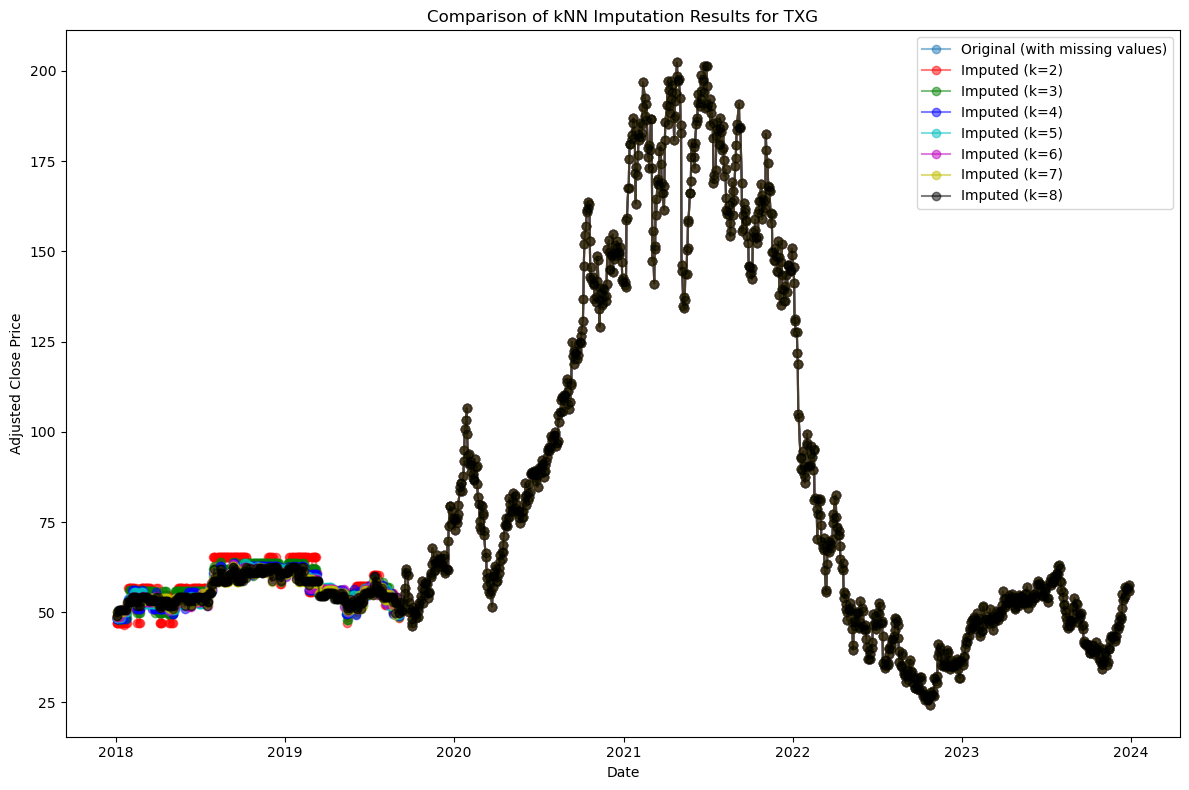

In [69]:
evaluate_imputation(imputed_results, original_data)

In [74]:
def evaluate_imputation_for_all_ks(imputed_results, original_data):
    if len(original_data.columns) > 0:
        ticker = original_data.columns[0]
        ticker_2 = original_data.columns[1]

        n_plots = len(imputed_results)

        n_cols = min(2, n_plots)
        n_rows = (n_plots + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharex=True, sharey=True)
        
        if n_plots == 1:
            axes = np.array([axes])

        if n_plots > 1:
            axes = axes.flatten()

        for i, (k, imputed_df) in enumerate(imputed_results.items()):
            ax = axes[i]
        
            ax.plot(original_data.index, original_data[ticker_2], 'o-', 
                   label='Original (with missing values)', alpha=0.5, color='black')
            
            ax.plot(imputed_df.index, imputed_df[ticker_2], 'o-', 
                   color='red', label=f'Imputed (k={k})', alpha=0.7)
            
            ax.set_title(f'kNN Imputation (k={k}) for {ticker_2}')
            ax.set_ylabel('Adjusted Close Price')
            ax.legend()

            if i >= n_plots - n_cols:
                ax.set_xlabel('Date')
        
  
        for j in range(n_plots, len(axes)):
            fig.delaxes(axes[j])
        
        plt.tight_layout()
        #plt.savefig('imputation_comparison_subplots.png')
        #plt.close()
        #print("Saved imputation comparison plot as 'imputation_comparison_subplots.png'")

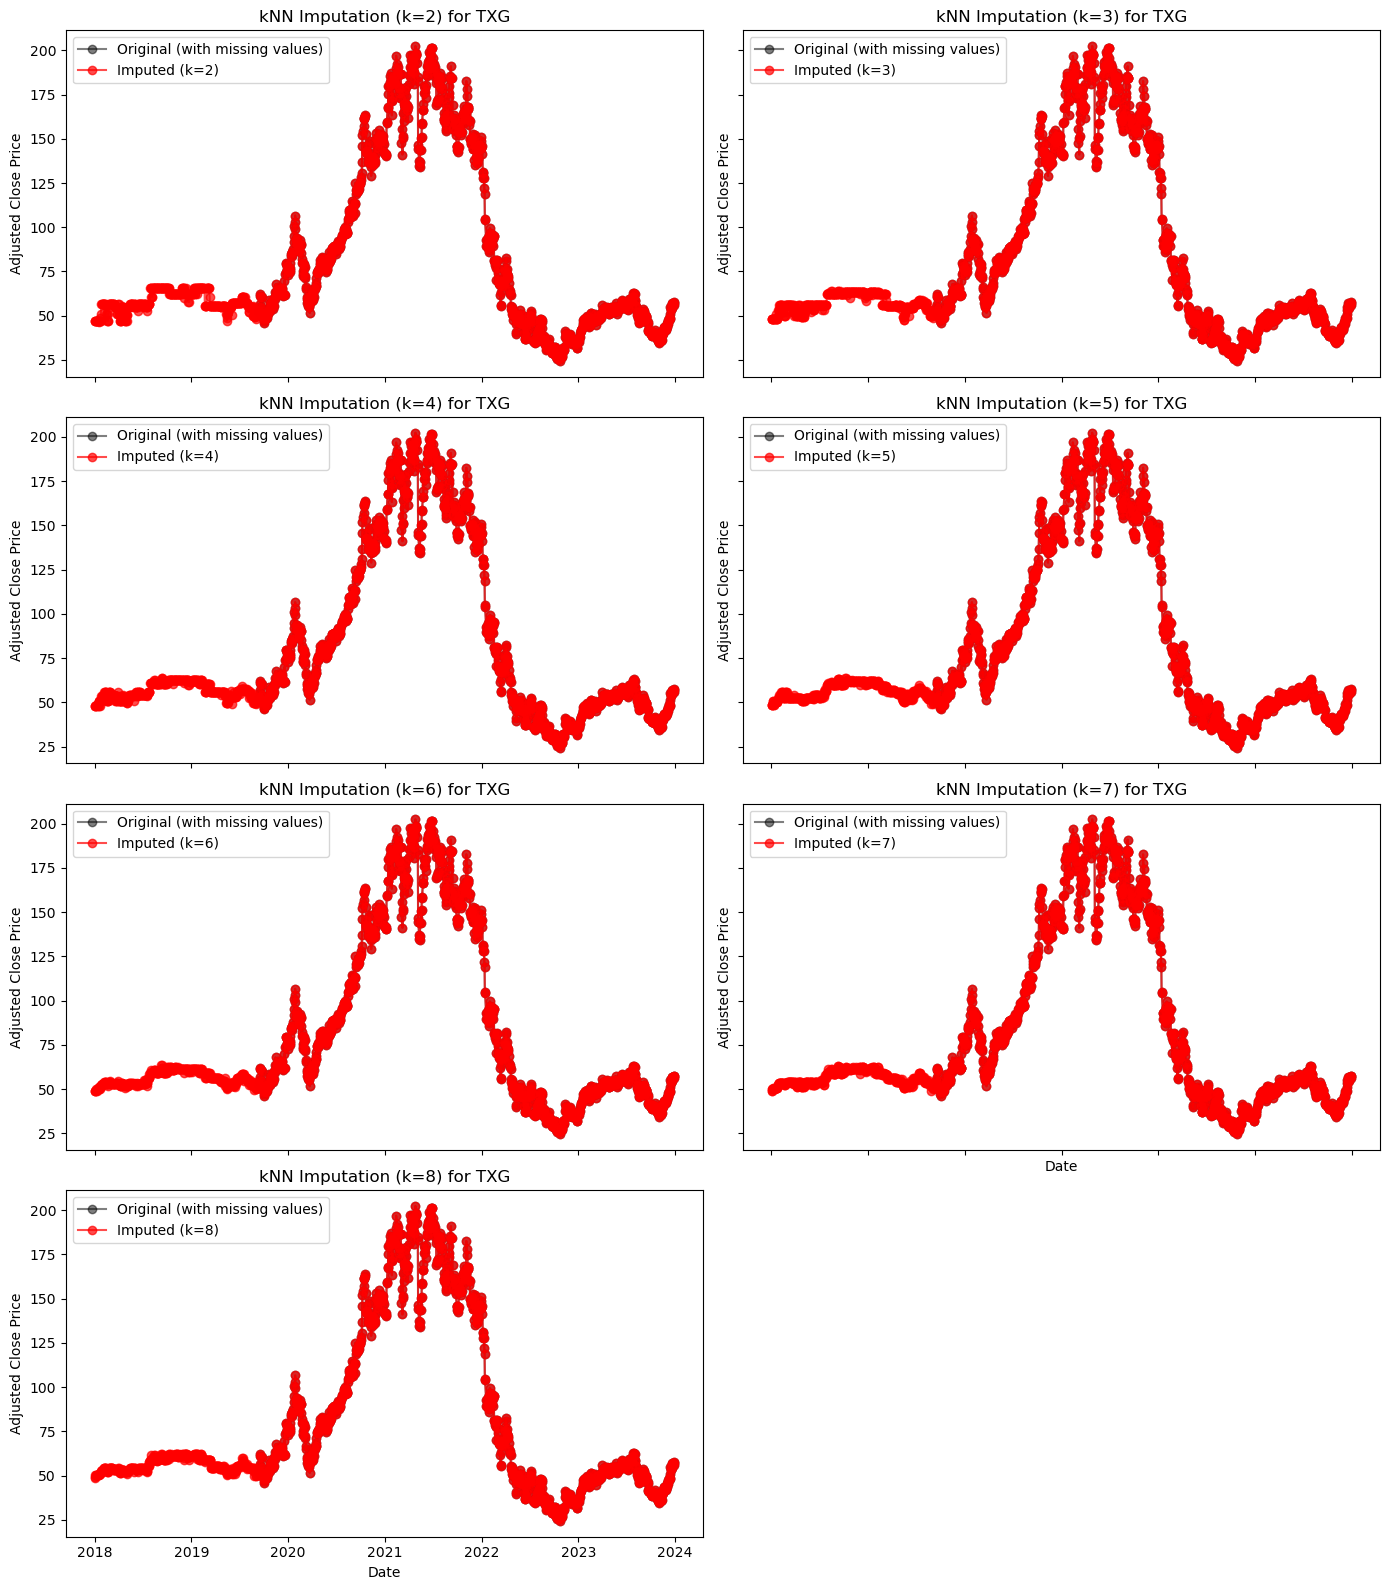

In [71]:
evaluate_imputation_for_all_ks(imputed_results, original_data)

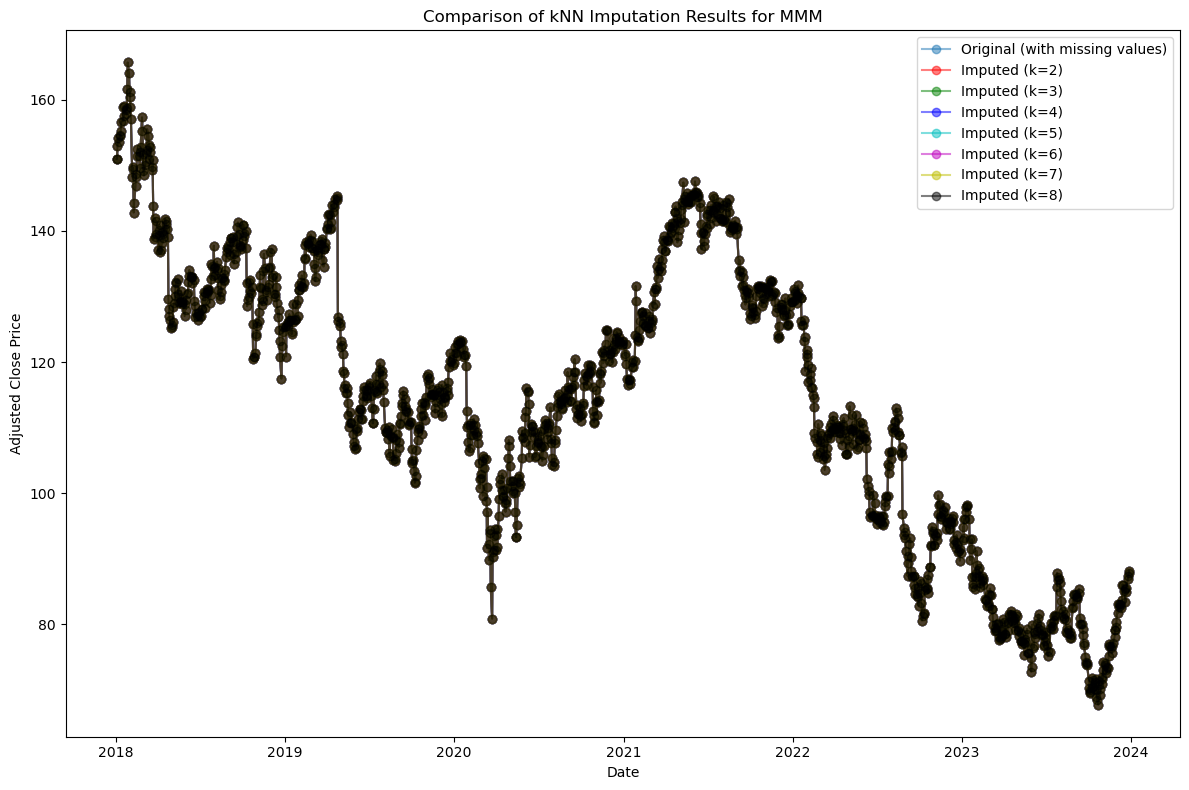

In [73]:
evaluate_imputation(imputed_results, original_data)

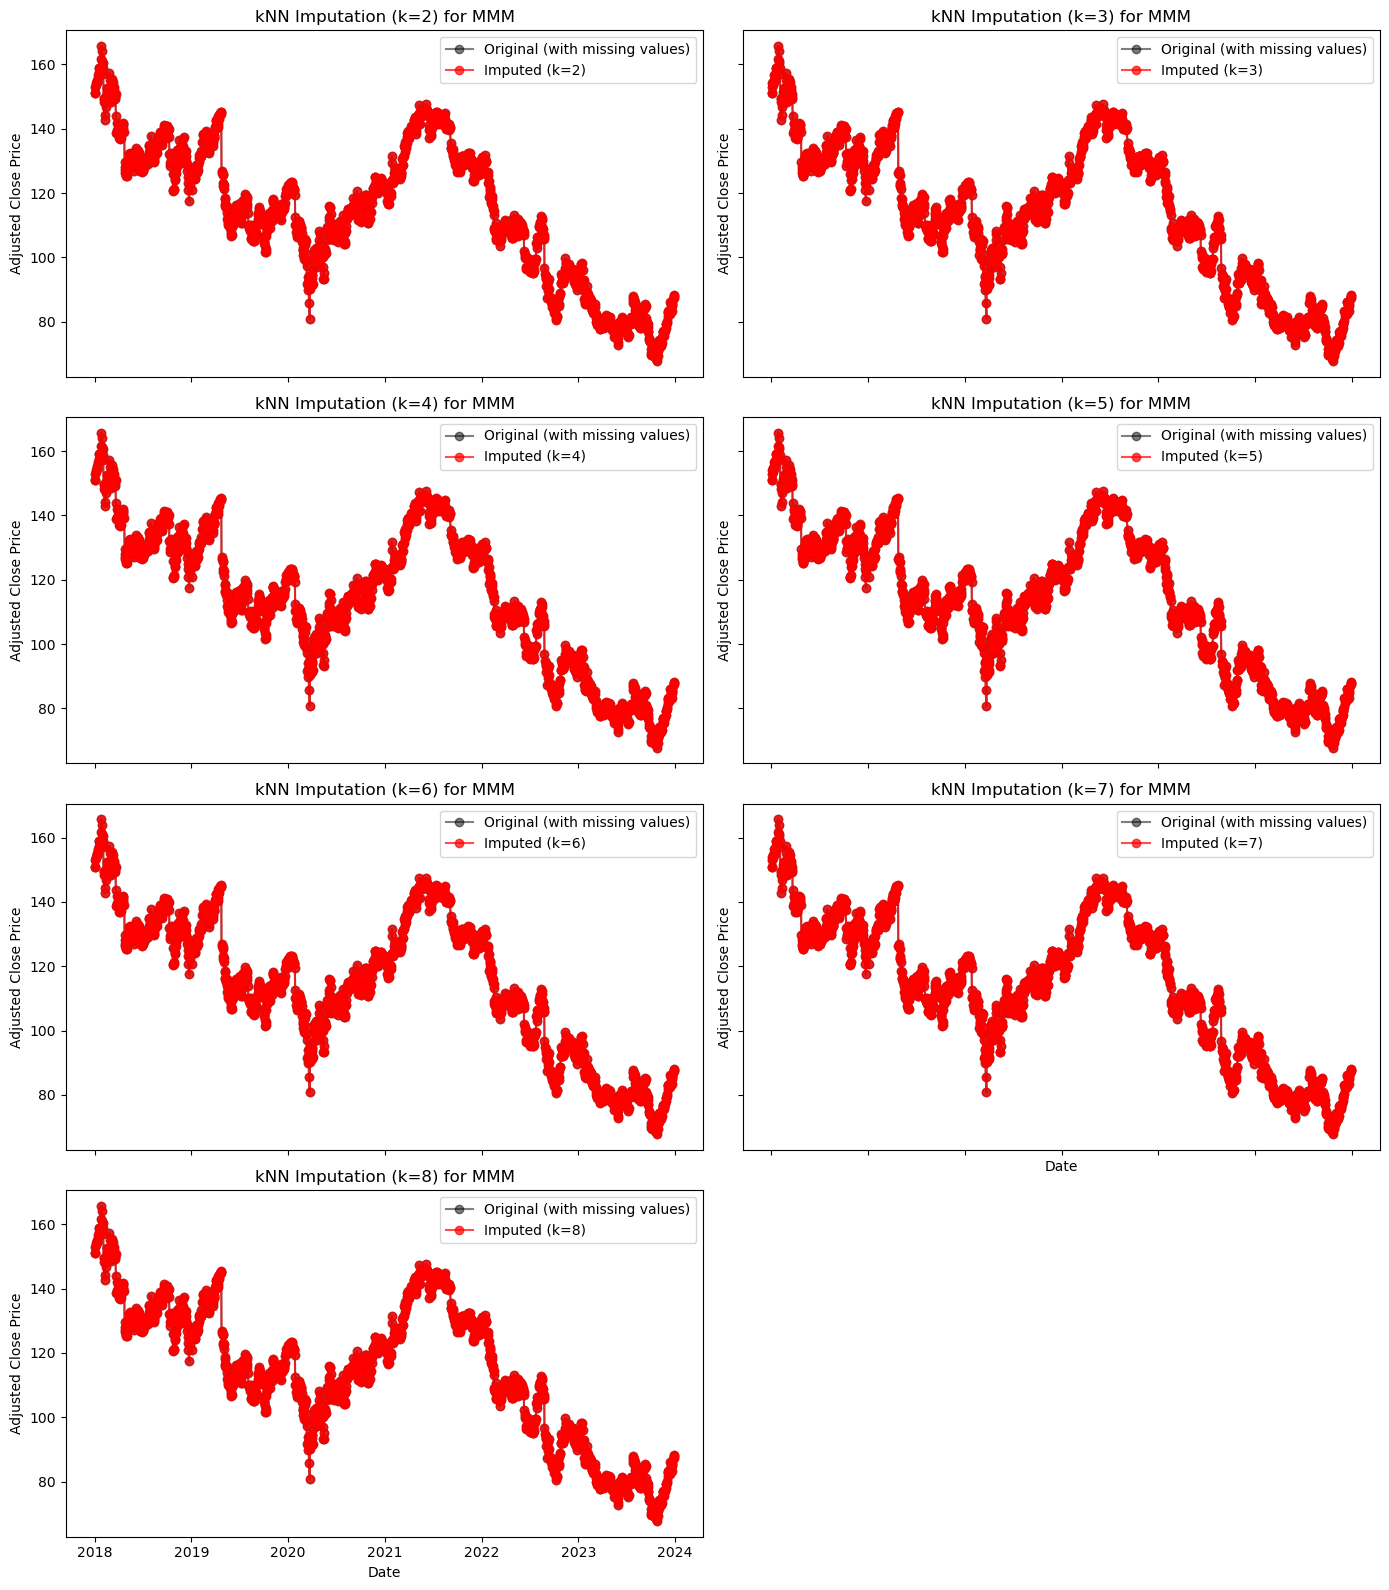

In [75]:
evaluate_imputation_for_all_ks(imputed_results, original_data)

## Problem 3: Handling Missing Data

In this problem, we will be handling the problem of datasets with missing values. Clearly, we cannot simply remove entire rows or columns that contain missing values. In this problem, we explore two different ways to fill in missing values.

The datasets required for this problem is in the ``dataset`` directory. Each file in the ``dataset`` directory contains a one-dimensional data set, with the first column containing the independent variable X, and the second column containing the dependent variable Y.

The files ``dataset_1_missing.txt`` to ``dataset_6_missing.txt`` contains rows that are missing their y-values, where as ``dataset_1_full.txt`` to ``dataset_6_full.txt`` contain datasets with all y-values correctly filled in.

In this problem, you **may** use ``sklearn`` or build-in ``pandas`` functions to **directly fill in missing values**.

### Part (a): Model Based Data Imputation

- Describe in detail how predictive models for data (like KNN and simple linear regression) can be used to fill in missing values in a data set.


- Implement your scheme. That is, write code (preferably a function ``fill`` or two functions ``fill_knn``, ``fill_lin_reg``), which takes an ``n x 2`` dataframe or array with values missing in the 2nd column and fills in these values using KNN and linear regression. 


- You need to, also, write code to evaluate the quality of the values you've filled in.

**Solution:**

The idea behind KNN imputation is that similar observations tend to have similar values for attributes that are missing. KNN uses the available features to determine the distance (usually Euclidean distance) to all complete observations for each observation with missing values. KNN then finds k most similar observations (nearest neighbors) for missing values. Missing values can be imputed with average of values from these k neighbors.

Linear regression model can be use for imputing the missing variables with missing variables (Y) is the dependent variable and other known variables are predictors (X). Then model parameters are estimated based on minimze the MSE between predicted and target values. Fitted model can be used to predict missing values with using observed values of the predictor variables.

In [90]:
def load_data(file_path):
    data = pd.read_csv(file_path, names=['x', 'y'], header=0)
    data['y'] = pd.to_numeric(data['y'], errors='coerce')
    return data

In [91]:
def fill_knn(data, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    data_imputed = imputer.fit_transform(data)
    return pd.DataFrame(data_imputed, columns=['x', 'y'])

In [92]:
from sklearn.linear_model import LinearRegression

def fill_lin_reg(data):
    known = data.dropna()
    unknown = data[data['y'].isna()].copy()  #  without .copy() I am getting warning about data being modified 

    model = LinearRegression()
    model.fit(known[['x']], known['y'])
    
    # with iloc, I got a warning
    unknown.loc[:, 'y'] = model.predict(unknown[['x']])
    
    data_imputed = pd.concat([known, unknown])
    return data_imputed.sort_index()

In [93]:
from sklearn.metrics import r2_score

def evaluate_imputation(imputed_data, full_data):
    merged_data = pd.merge(imputed_data, full_data, on='x', suffixes=('_imputed', '_true'))
    
    r2 = r2_score(merged_data['y_true'], merged_data['y_imputed'])
    return r2

In [94]:
import matplotlib.pyplot as plt

def plot_imputation_results(imputed_data, full_data, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(full_data['x'], full_data['y'], color='blue', label='True Values', alpha=0.6)
    plt.scatter(imputed_data['x'], imputed_data['y'], color='red', label='Imputed Values', alpha=0.6)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [95]:
missing_data = load_data("dataset/dataset_1_missing.txt")
full_data = load_data("dataset/dataset_1_full.txt")

In [96]:
print("Missing Data:")
print(missing_data.head())

Missing Data:
          x         y
0  0.177418  1.401178
1  0.573076       NaN
2  0.503775  1.684924
3  0.594027  3.898209
4  0.335754       NaN


In [97]:
print("\nFull Data:")
print(full_data.head())


Full Data:
          x         y
0  0.177418  1.401178
1  0.573076  3.489890
2  0.503775  1.684924
3  0.594027  3.898209
4  0.335754  2.878410


In [98]:
knn_imputed_data = fill_knn(missing_data)
print("KNN Imputed Data:")
print(knn_imputed_data.head())

KNN Imputed Data:
          x         y
0  0.177418  1.401178
1  0.573076  2.869925
2  0.503775  1.684924
3  0.594027  3.898209
4  0.335754  2.798072


In [99]:
lin_reg_imputed_data = fill_lin_reg(missing_data)

print("Linear Regression Imputed Data:")
print(lin_reg_imputed_data.head())

Linear Regression Imputed Data:
          x         y
0  0.177418  1.401178
1  0.573076  2.712322
2  0.503775  1.684924
3  0.594027  3.898209
4  0.335754  2.014892


We can compare the models for imputation with R^2 values which calculated based on the original and imputed values. In this case for example (for dataset_1), Linear Regression is better for imputation because R^2 is higher than KNN.

In [100]:
knn_r2 = evaluate_imputation(knn_imputed_data, full_data)
print(f"KNN Imputation R² Score: {knn_r2:.4f}")

lin_reg_r2 = evaluate_imputation(lin_reg_imputed_data, full_data)
print(f"Linear Regression Imputation R² Score: {lin_reg_r2:.4f}")

KNN Imputation R² Score: 0.7950
Linear Regression Imputation R² Score: 0.8258


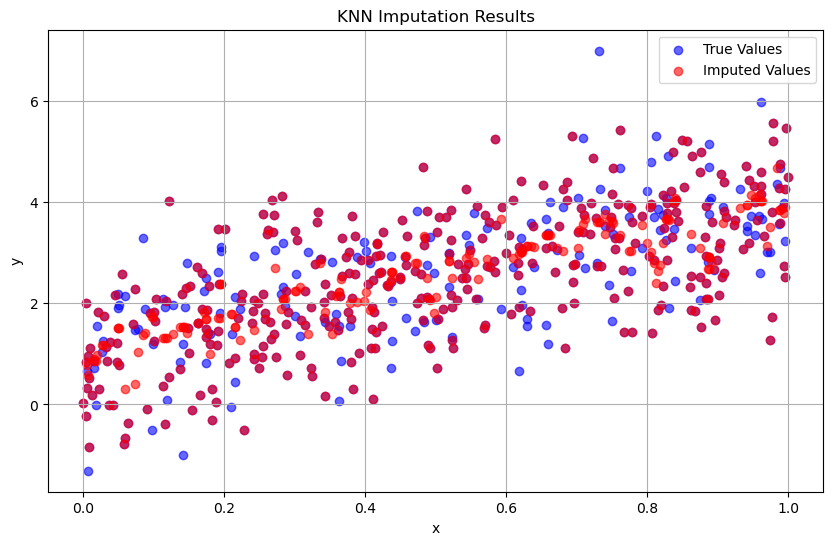

In [101]:
plot_imputation_results(knn_imputed_data, full_data, "KNN Imputation Results")

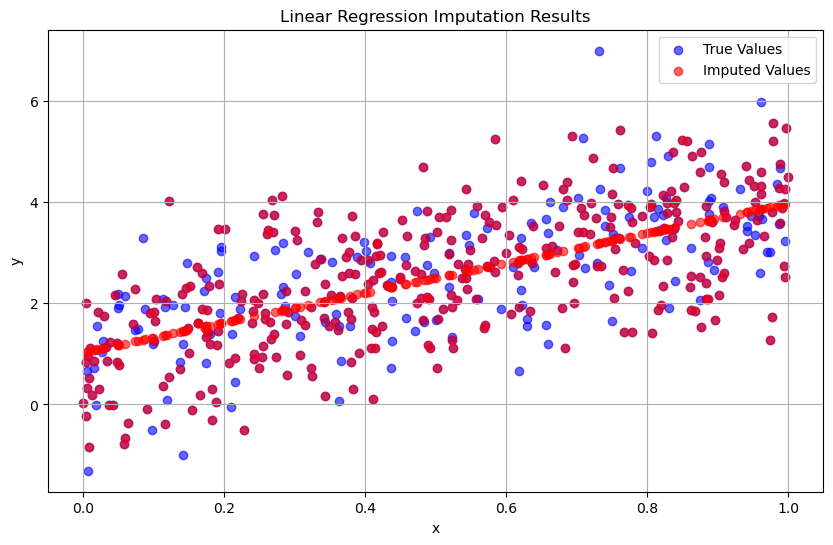

In [102]:
plot_imputation_results(lin_reg_imputed_data, full_data, "Linear Regression Imputation Results")

In [103]:
missing_data_2 = load_data("dataset/dataset_2_missing.txt")
full_data_2 = load_data("dataset/dataset_2_full.txt")

In [104]:
knn_imputed_data_2 = fill_knn(missing_data_2)
print("KNN Imputed Data:")
print(knn_imputed_data_2.head())

KNN Imputed Data:
          x         y
0  0.408443  0.292108
1  0.640883  7.827852
2  0.637759  7.670475
3  0.581426  6.794274
4  0.772800  7.879239


In [105]:
lin_reg_imputed_data_2 = fill_lin_reg(missing_data_2)

print("Linear Regression Imputed Data:")
print(lin_reg_imputed_data_2.head())

Linear Regression Imputed Data:
          x         y
0  0.408443  0.292108
1  0.640883  5.400129
2  0.637759  5.356153
3  0.581426  4.563193
4  0.772800  7.879239


In [106]:
knn_r2_2 = evaluate_imputation(knn_imputed_data_2, full_data_2)
print(f"KNN Imputation R² Score: {knn_r2_2:.4f}")

lin_reg_r2_2 = evaluate_imputation(lin_reg_imputed_data_2, full_data_2)
print(f"Linear Regression Imputation R² Score: {lin_reg_r2_2:.4f}")

KNN Imputation R² Score: 0.9802
Linear Regression Imputation R² Score: 0.9564


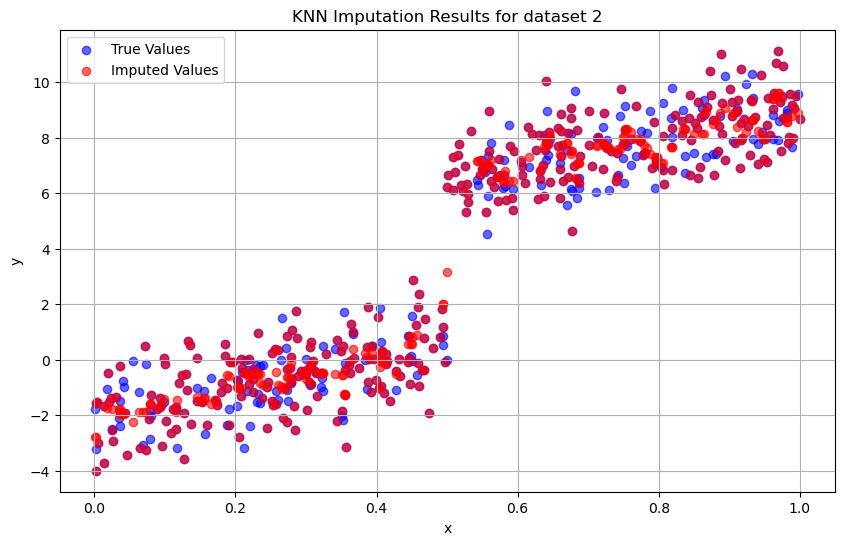

In [107]:
plot_imputation_results(knn_imputed_data_2, full_data_2, "KNN Imputation Results for dataset 2")

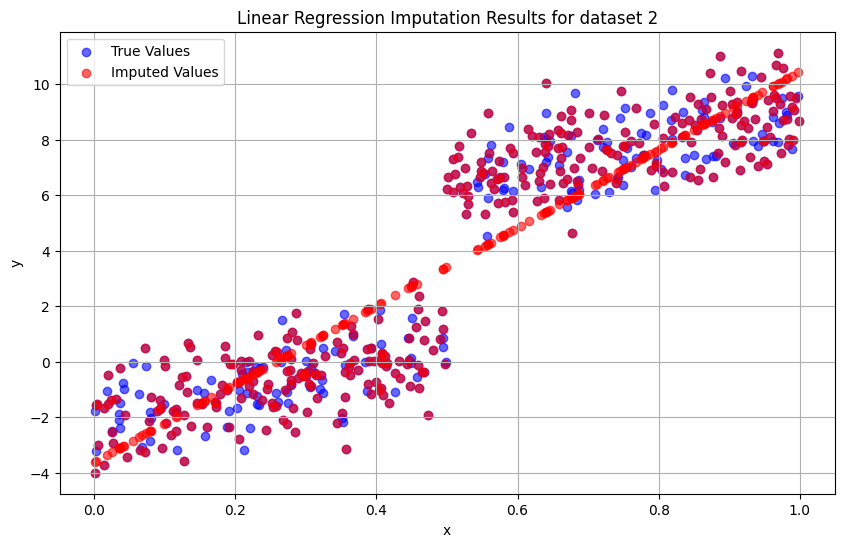

In [93]:
plot_imputation_results(lin_reg_imputed_data_2, full_data_2, "Linear Regression Imputation Results for dataset 2")

In [108]:
def process_all_datasets(dataset_paths):
    results = []
    
    for i in range(1, 7):  # from 1 to 6 for dataset
    
        missing_data = load_data(f"{dataset_paths}/dataset_{i}_missing.txt")
        full_data = load_data(f"{dataset_paths}/dataset_{i}_full.txt")
        
        knn_imputed_data = fill_knn(missing_data)
        knn_r2 = evaluate_imputation(knn_imputed_data, full_data)
        
        lin_reg_imputed_data = fill_lin_reg(missing_data)
        lin_reg_r2 = evaluate_imputation(lin_reg_imputed_data, full_data)
        
        results.append({
            'Dataset': i,
            'KNN R²': knn_r2,
            'Linear Regression R²': lin_reg_r2
        })
        
        print(f"Dataset {i}:")
        print(f"KNN R²: {knn_r2:.4f}")
        print(f"Linear Regression R²: {lin_reg_r2:.4f}")
        print("-" * 40)
    
    return pd.DataFrame(results)

In [109]:
dataset_paths = "dataset"
results = process_all_datasets(dataset_paths)

print("\nSummary of Results:")
print(results)

Dataset 1:
KNN R²: 0.7950
Linear Regression R²: 0.8258
----------------------------------------
Dataset 2:
KNN R²: 0.9802
Linear Regression R²: 0.9564
----------------------------------------
Dataset 3:
KNN R²: 0.6169
Linear Regression R²: 0.7065
----------------------------------------
Dataset 4:
KNN R²: 0.9476
Linear Regression R²: 0.8951
----------------------------------------
Dataset 5:
KNN R²: 0.9050
Linear Regression R²: 0.7500
----------------------------------------
Dataset 6:
KNN R²: 0.7165
Linear Regression R²: 0.7737
----------------------------------------

Summary of Results:
   Dataset    KNN R²  Linear Regression R²
0        1  0.794993              0.825825
1        2  0.980211              0.956435
2        3  0.616860              0.706488
3        4  0.947571              0.895122
4        5  0.905010              0.749963
5        6  0.716491              0.773700


### Part (b): Which Model is Better?

- For datasets ``dataset_1_missing.txt`` to ``dataset_6_missing.txt``, compare the result of filling in the missing values using KNN and linear regression, using both the R^2 coefficient as well as data visualization (the correct y-values are contained in ``dataset_1_full.txt`` to ``dataset_6_full.txt``).. 


- Use your analysis to form conjectures regarding the conditions under which KNN performs better than linear regression, under which linear regression performs better than KNN and under which both perform equally (well or poorly). Explain in detail exactly what might cause each model to fail or perform well. 



- Using ``dataset_1_missing.txt``, explain the impact of the choice of $k$ on the performance of KNN. 


Use numerical analysis and data visualization to support every part of your argument.

**Solution:**

In [94]:
def visualize_comparison(results):
    plt.figure(figsize=(10, 6))
    plt.plot(results['Dataset'], results['KNN R²'], label='KNN R²', marker='o')
    plt.plot(results['Dataset'], results['Linear Regression R²'], label='Linear Regression R²', marker='o')
    plt.xlabel('Dataset')
    plt.ylabel('R² Score')
    plt.title('Comparison of KNN and Linear Regression Imputation Across Datasets')
    plt.legend()
    plt.grid(True)
    plt.show()

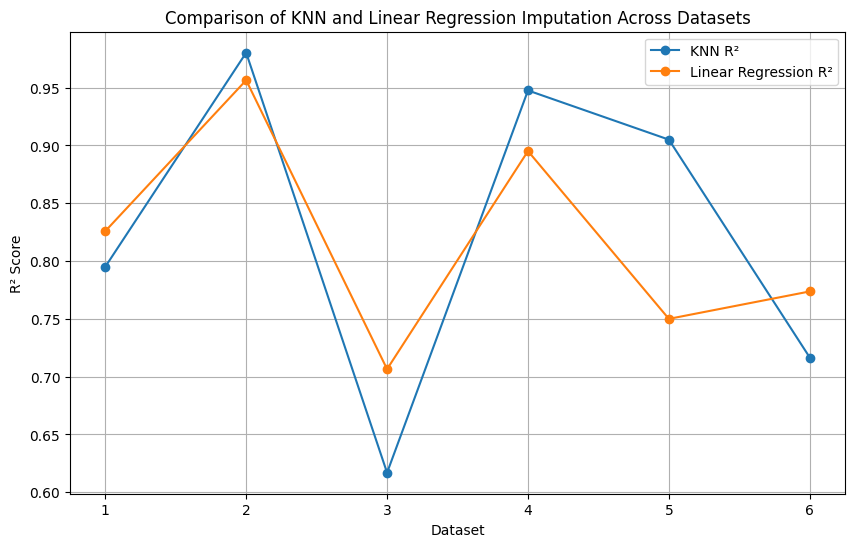

In [95]:
visualize_comparison(results)

We can analyze the models with R^2 values for each dataset to compare imputed and the original ones. We need to select predictive model with a higher R^2 value for better imputation.
For dataset_1, Linear Regression model has higher R^2 value so we need to select Linear Regression for imputation in dataset_1.
For dataset_2, KNN has higher R^2 value so we need to select Linear Regression for imputation in dataset_2.
For dataset_3, Linear Regression model has higher R^2 value so we need to select Linear Regression for imputation in dataset_3.
For dataset_4, KNN has higher R^2 value so we need to select Linear Regression for imputation in dataset_4.
For dataset_5, KNN has higher R^2 value so we need to select Linear Regression for imputation in dataset_5.
For dataset_6, Linear Regression model has higher R^2 value so we need to select Linear Regression for imputation in dataset_6.

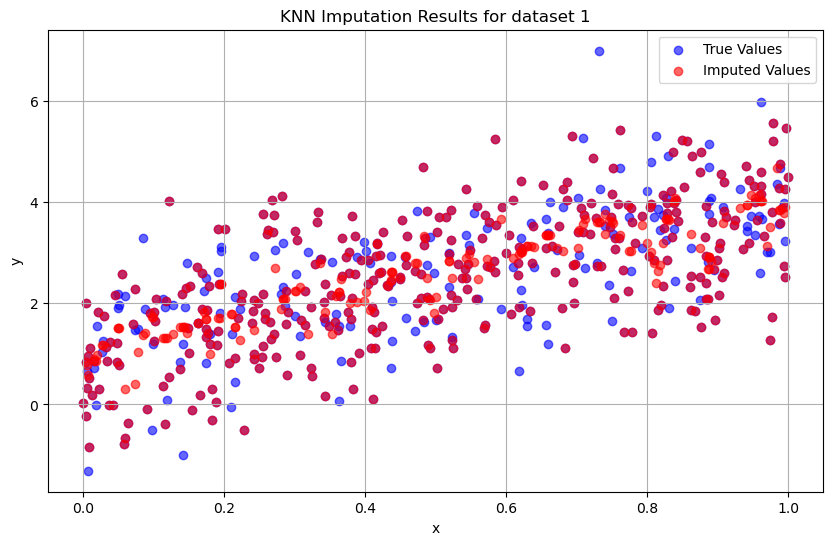

In [110]:
plot_imputation_results(knn_imputed_data, full_data, "KNN Imputation Results for dataset 1")

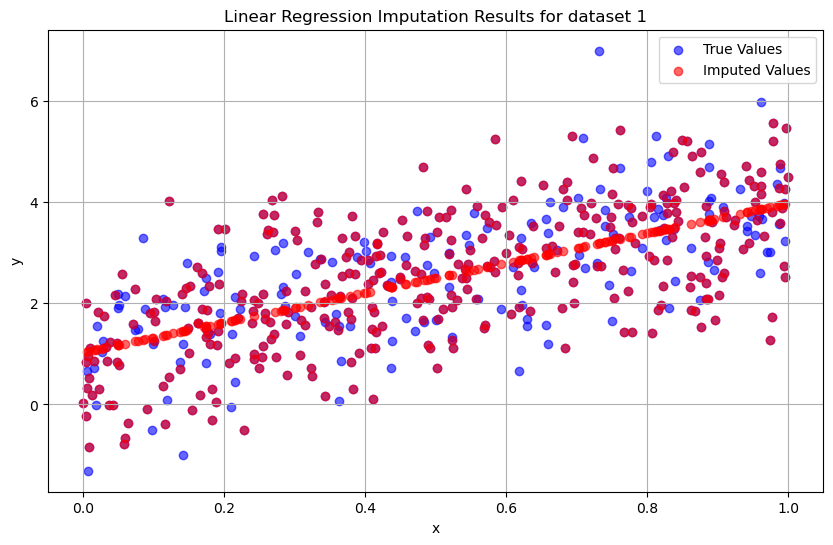

In [113]:
plot_imputation_results(lin_reg_imputed_data, full_data, "Linear Regression Imputation Results for dataset 1")

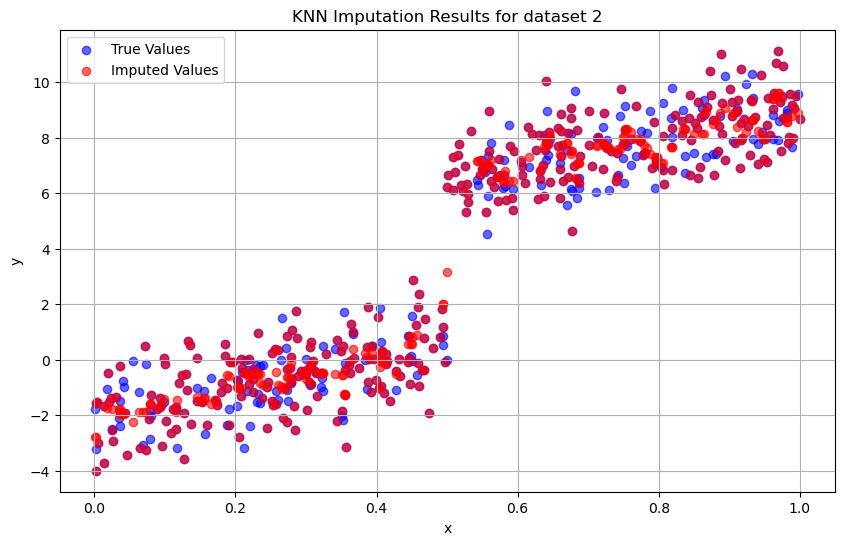

In [111]:
plot_imputation_results(knn_imputed_data_2, full_data_2, "KNN Imputation Results for dataset 2")

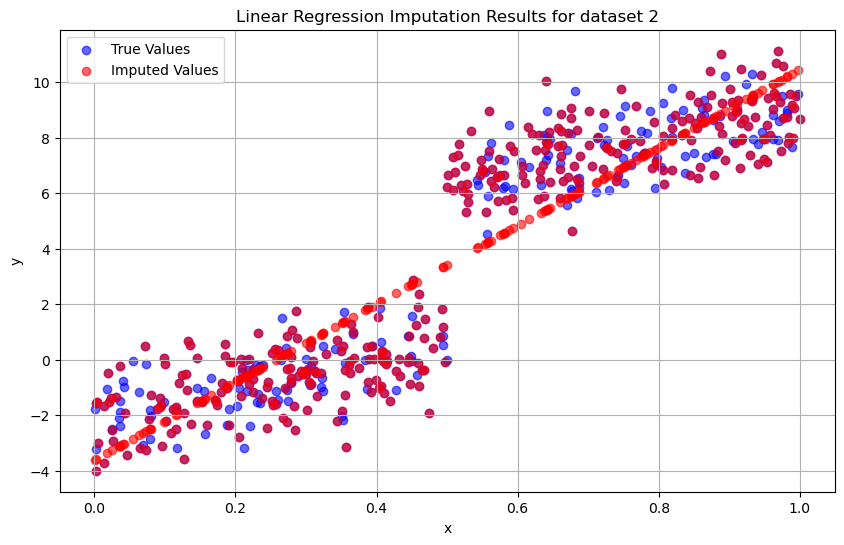

In [114]:
plot_imputation_results(lin_reg_imputed_data_2, full_data_2, "Linear Regression Imputation Results for dataset 2")

In [116]:
missing_data_3 = load_data("dataset/dataset_3_missing.txt")
full_data_3 = load_data("dataset/dataset_3_full.txt")

In [120]:
knn_imputed_data_3 = fill_knn(missing_data_3)
print("KNN Imputed Data for dataset 3:")
print(knn_imputed_data_3.head())

KNN Imputed Data for dataset 3:
          x          y
0  0.121384   0.652730
1  0.160069   5.373957
2  0.004706   2.142096
3  0.571459  10.261394
4  0.259522   4.797792


In [124]:
lin_reg_imputed_data_3 = fill_lin_reg(missing_data_3)

print("Linear Regression Imputed Data for dataset 3:")
print(lin_reg_imputed_data_3.head())

Linear Regression Imputed Data for dataset 3:
          x          y
0  0.121384   3.030425
1  0.160069   5.373957
2  0.004706   2.396596
3  0.571459  10.261394
4  0.259522   3.780826


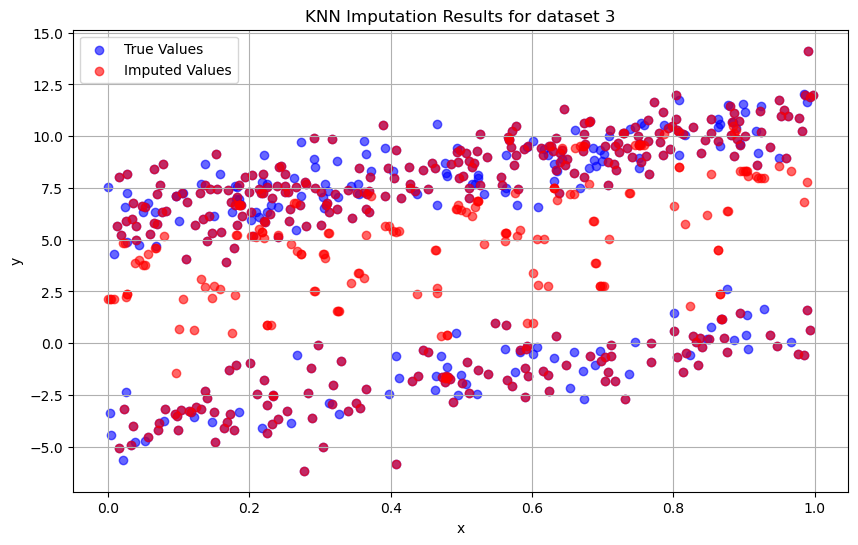

In [128]:
plot_imputation_results(knn_imputed_data_3, full_data_3, "KNN Imputation Results for dataset 3")

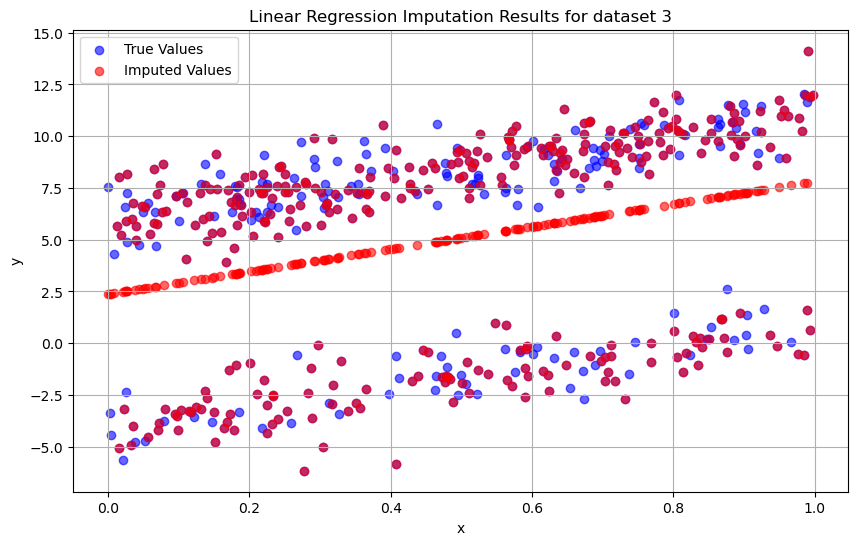

In [129]:
plot_imputation_results(lin_reg_imputed_data_3, full_data_3, "Linear Regression Imputation Results for dataset 3")

In [117]:
missing_data_4 = load_data("dataset/dataset_4_missing.txt")
full_data_4 = load_data("dataset/dataset_4_full.txt")

In [121]:
knn_imputed_data_4 = fill_knn(missing_data_4)
print("KNN Imputed Data for dataset 4:")
print(knn_imputed_data_4.head())

KNN Imputed Data for dataset 4:
          x        y
0  0.016353  0.91325
1  0.727570  0.36886
2  0.627700  0.14077
3  0.832000  0.24985
4  0.163920  1.22470


In [125]:
lin_reg_imputed_data_4 = fill_lin_reg(missing_data_4)

print("Linear Regression Imputed Data for dataset 4:")
print(lin_reg_imputed_data_4.head())

Linear Regression Imputed Data for dataset 4:
          x        y
0  0.016353  0.91325
1  0.727570  0.36886
2  0.627700  0.14077
3  0.832000  0.24985
4  0.163920  1.22470


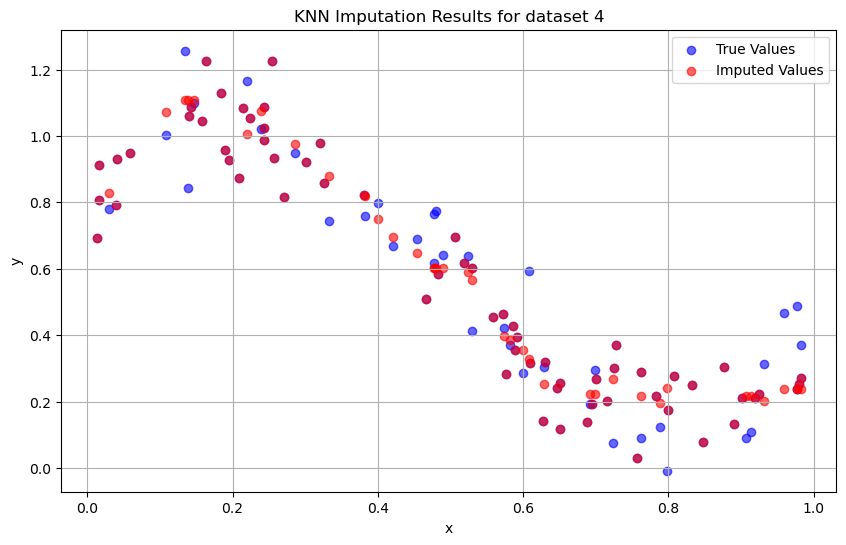

In [130]:
plot_imputation_results(knn_imputed_data_4, full_data_4, "KNN Imputation Results for dataset 4")

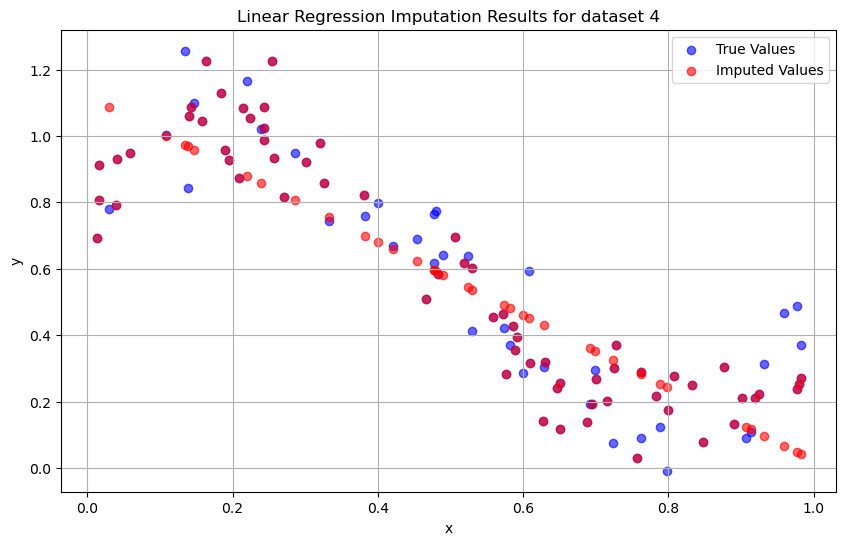

In [131]:
plot_imputation_results(lin_reg_imputed_data_4, full_data_4, "Linear Regression Imputation Results for dataset 4")

In [118]:
missing_data_5 = load_data("dataset/dataset_5_missing.txt")
full_data_5 = load_data("dataset/dataset_5_full.txt")

In [122]:
knn_imputed_data_5 = fill_knn(missing_data_5)
print("KNN Imputed Data for dataset 5")
print(knn_imputed_data_5.head())

KNN Imputed Data for dataset 5
         x        y
0  0.21376  0.87153
1  0.29810  0.66928
2  0.76834  1.17930
3  0.50115  1.92772
4  0.90946  2.26466


In [126]:
lin_reg_imputed_data_5 = fill_lin_reg(missing_data_5)

print("Linear Regression Imputed Data for dataset 5:")
print(lin_reg_imputed_data_5.head())

Linear Regression Imputed Data for dataset 5:
         x        y
0  0.21376  0.87153
1  0.29810  0.66928
2  0.76834  1.17930
3  0.50115  1.39690
4  0.90946  1.73931


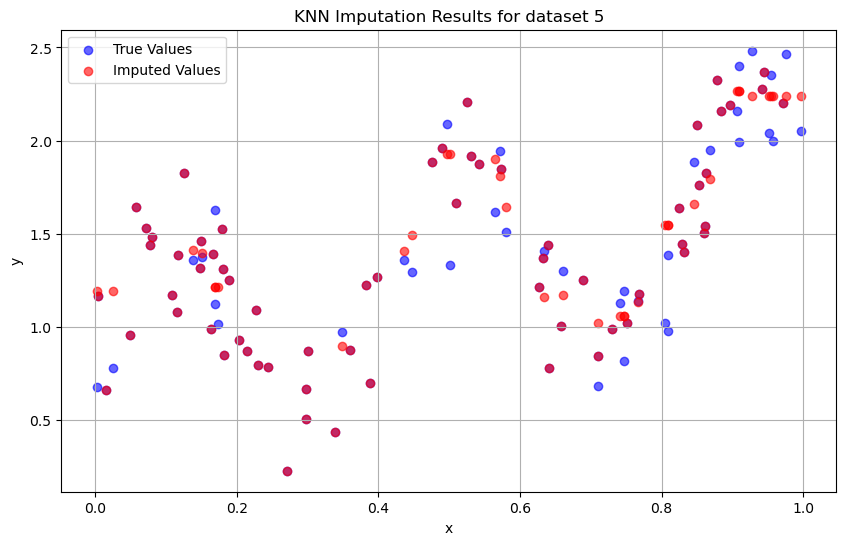

In [133]:
plot_imputation_results(knn_imputed_data_5, full_data_5, "KNN Imputation Results for dataset 5")

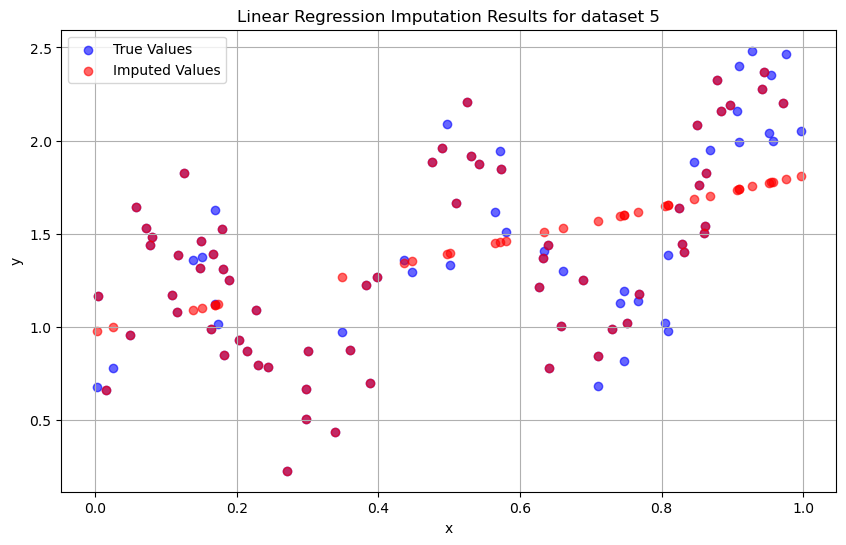

In [132]:
plot_imputation_results(lin_reg_imputed_data_5, full_data_5, "Linear Regression Imputation Results for dataset 5")

In [119]:
missing_data_6 = load_data("dataset/dataset_6_missing.txt")
full_data_6 = load_data("dataset/dataset_6_full.txt")

In [123]:
knn_imputed_data_6 = fill_knn(missing_data_6)
print("KNN Imputed Data for dataset 6:")
print(knn_imputed_data_6.head())

KNN Imputed Data for dataset 6:
          x         y
0  0.665138  5.072733
1  0.008478  1.084748
2  0.832568  6.074897
3  0.168644  1.742910
4  0.652890  5.440666


In [127]:
lin_reg_imputed_data_6 = fill_lin_reg(missing_data_6)

print("Linear Regression Imputed Data for dataset 6:")
print(lin_reg_imputed_data_6.head())

Linear Regression Imputed Data for dataset 6:
          x         y
0  0.665138  4.371069
1  0.008478  1.084748
2  0.832568  5.221746
3  0.168644  1.848484
4  0.652890  5.440666


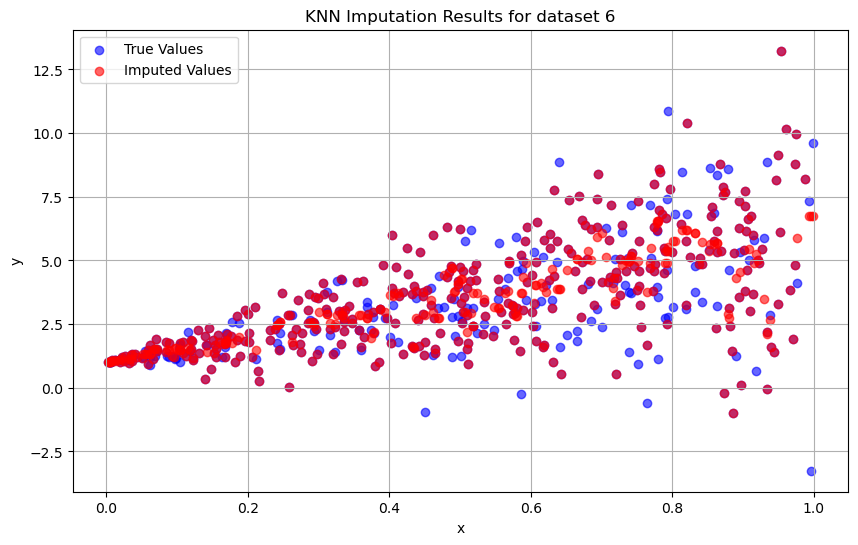

In [134]:
plot_imputation_results(knn_imputed_data_6, full_data_6, "KNN Imputation Results for dataset 6")

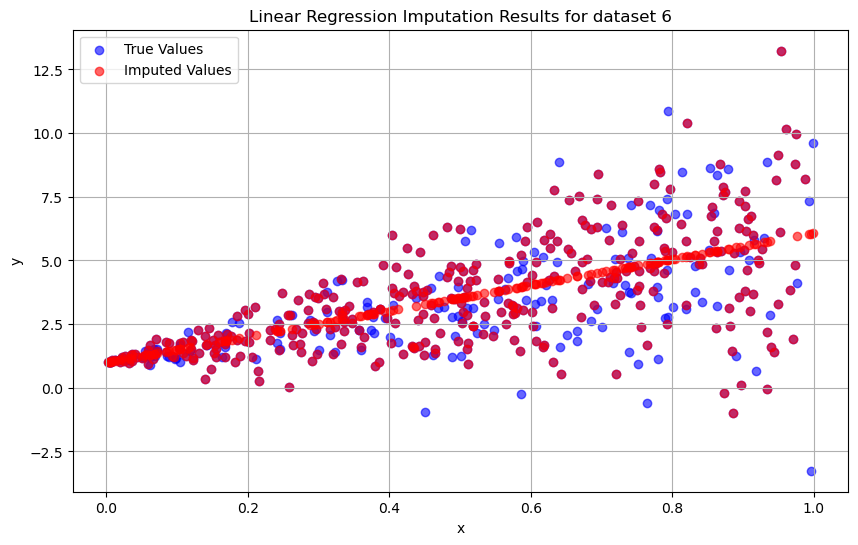

In [135]:
plot_imputation_results(lin_reg_imputed_data_6, full_data_6, "Linear Regression Imputation Results for dataset 6")

In [98]:
def analyze_k_impact(dataset_paths, dataset_num=1):
    missing_data = load_data(f"{dataset_paths}/dataset_{dataset_num}_missing.txt")
    full_data = load_data(f"{dataset_paths}/dataset_{dataset_num}_full.txt")
    
    k_values = range(1, 21) 
    r2_scores = []
    
    for k in k_values:
        knn_imputed_data = fill_knn(missing_data, n_neighbors=k)
        r2 = evaluate_imputation(knn_imputed_data, full_data)
        print(f"r2 for k value {k}: {r2}")
        r2_scores.append(r2)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, r2_scores, marker='o')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('R² Score')
    plt.title(f'Impact of k on KNN Imputation Performance (Dataset {dataset_num})')
    plt.grid(True)
    plt.show()

r2 for k value 1: 0.6678132326598673
r2 for k value 2: 0.7454153931709324
r2 for k value 3: 0.7693206016720442
r2 for k value 4: 0.7948317744864386
r2 for k value 5: 0.7949928639193149
r2 for k value 6: 0.7960608726322806
r2 for k value 7: 0.7953086893601722
r2 for k value 8: 0.795005353725294
r2 for k value 9: 0.8006133473931847
r2 for k value 10: 0.7971176975117552
r2 for k value 11: 0.7957146765286053
r2 for k value 12: 0.8002928767714608
r2 for k value 13: 0.8010341436554962
r2 for k value 14: 0.8037025103755031
r2 for k value 15: 0.8090284941739817
r2 for k value 16: 0.8117726700979561
r2 for k value 17: 0.8137752136017431
r2 for k value 18: 0.8147299879021686
r2 for k value 19: 0.8177050581491412
r2 for k value 20: 0.8191523283063954


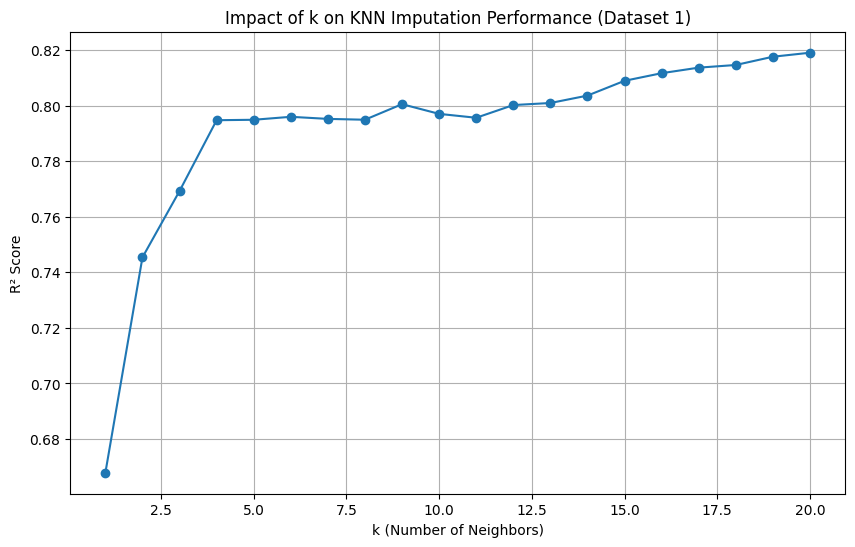

In [99]:
analyze_k_impact("dataset", dataset_num=1)

When we use higher number for k value in KNN, dataset has performed with higher R^2 value for the imputed values. With more neighbor values to the computed centers, imputation results have developed. For example with 5 neighbors, R^2 value is around 0.79 but with 20 neighbors R^2 value is around 0.82. 

r2 for k value 1: 0.9613520716564773
r2 for k value 2: 0.9758955874661136
r2 for k value 3: 0.9790277831806765
r2 for k value 4: 0.9798719272867511
r2 for k value 5: 0.980211178813414
r2 for k value 6: 0.9809994939483547
r2 for k value 7: 0.9807706923820168
r2 for k value 8: 0.9802617987948195
r2 for k value 9: 0.9807742592430587
r2 for k value 10: 0.9800902992667238
r2 for k value 11: 0.9801443626279578
r2 for k value 12: 0.9804620819910808
r2 for k value 13: 0.9800945558513225
r2 for k value 14: 0.9798615675695408
r2 for k value 15: 0.9802866942305315
r2 for k value 16: 0.9804293128618442
r2 for k value 17: 0.9808239700525343
r2 for k value 18: 0.9807387237016959
r2 for k value 19: 0.9812868764593741
r2 for k value 20: 0.9809601194661435


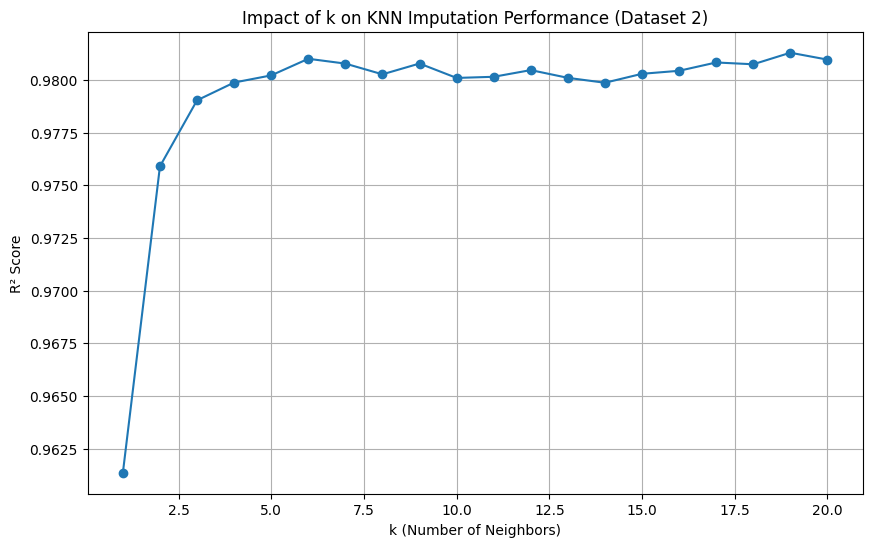

In [100]:
analyze_k_impact("dataset", dataset_num=2)

r2 for k value 1: 0.38385381744708436
r2 for k value 2: 0.5271253599166107
r2 for k value 3: 0.6087781688126077
r2 for k value 4: 0.609304274116659
r2 for k value 5: 0.6168603524371388
r2 for k value 6: 0.6237910104835991
r2 for k value 7: 0.6300100026770317
r2 for k value 8: 0.6489615521394805
r2 for k value 9: 0.6600895657935175
r2 for k value 10: 0.6606176144885572
r2 for k value 11: 0.6692471266194676
r2 for k value 12: 0.6723710131622118
r2 for k value 13: 0.676253251264745
r2 for k value 14: 0.6798534325480384
r2 for k value 15: 0.6870592818222541
r2 for k value 16: 0.6911692016979549
r2 for k value 17: 0.6975983837471513
r2 for k value 18: 0.6961361606672178
r2 for k value 19: 0.6973328727571904
r2 for k value 20: 0.6998363105121621


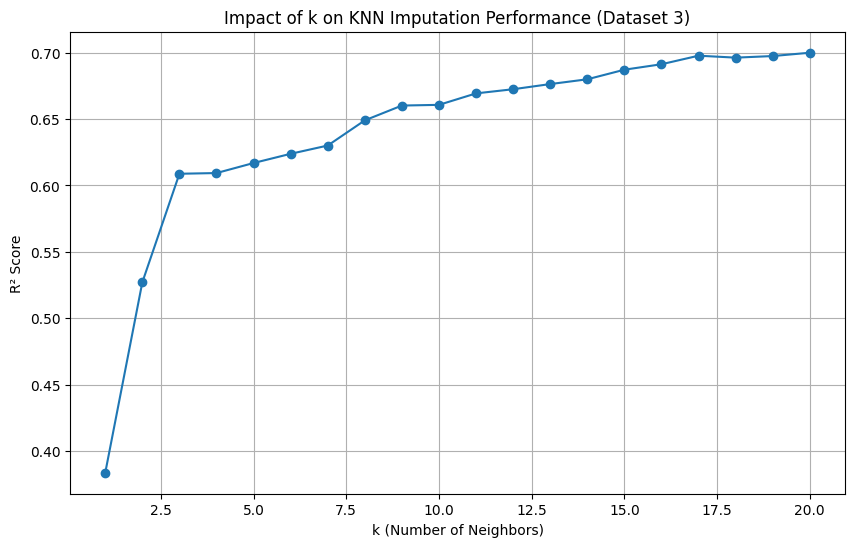

In [101]:
analyze_k_impact("dataset", dataset_num=3)

r2 for k value 1: 0.9388763875615468
r2 for k value 2: 0.9390144287481632
r2 for k value 3: 0.9453069528756765
r2 for k value 4: 0.9439021683363225
r2 for k value 5: 0.9475708592293545
r2 for k value 6: 0.9486100956865628
r2 for k value 7: 0.9434042660853066
r2 for k value 8: 0.943709788317725
r2 for k value 9: 0.9368178437956828
r2 for k value 10: 0.9350470368661267
r2 for k value 11: 0.9314417656137549
r2 for k value 12: 0.9303442653098086
r2 for k value 13: 0.9278366529585078
r2 for k value 14: 0.923168011188696
r2 for k value 15: 0.9241503533570746
r2 for k value 16: 0.924332331572447
r2 for k value 17: 0.9263307633471274
r2 for k value 18: 0.9245982094379228
r2 for k value 19: 0.9232529167066296
r2 for k value 20: 0.9185826802143676


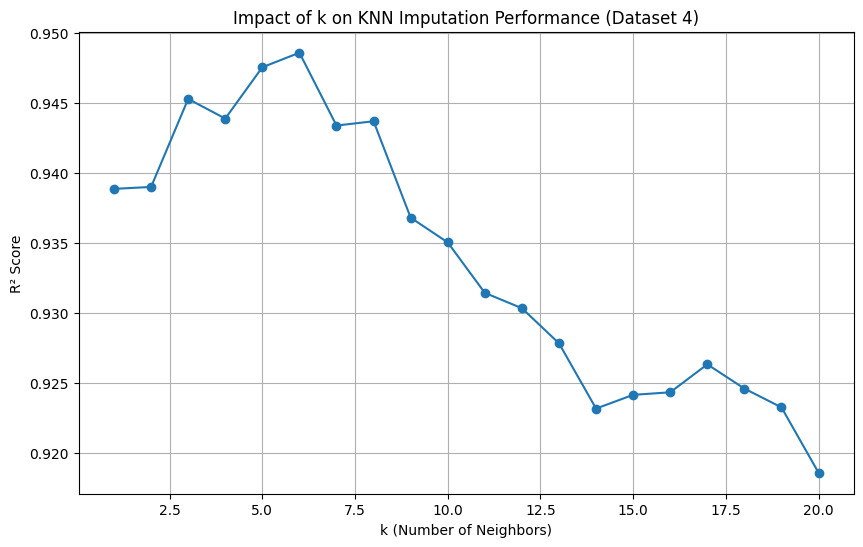

In [102]:
analyze_k_impact("dataset", dataset_num=4)

r2 for k value 1: 0.8708202418131619
r2 for k value 2: 0.894439248990148
r2 for k value 3: 0.9090907575220908
r2 for k value 4: 0.9185007391126393
r2 for k value 5: 0.9050099484113869
r2 for k value 6: 0.8988785120115375
r2 for k value 7: 0.8992737448677534
r2 for k value 8: 0.8931026906654469
r2 for k value 9: 0.8872520186042959
r2 for k value 10: 0.8844047712374791
r2 for k value 11: 0.872437555618467
r2 for k value 12: 0.8623880208709576
r2 for k value 13: 0.8518818759344501
r2 for k value 14: 0.8422496394937464
r2 for k value 15: 0.8299009221150309
r2 for k value 16: 0.8093310673865561
r2 for k value 17: 0.7864915063256289
r2 for k value 18: 0.7631759954591282
r2 for k value 19: 0.7498060884763987
r2 for k value 20: 0.7308264275432133


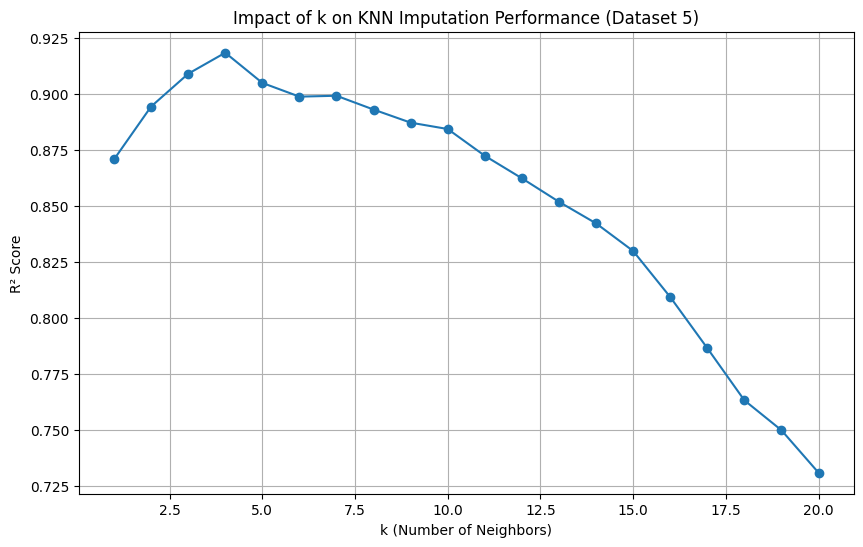

In [103]:
analyze_k_impact("dataset", dataset_num=5)

r2 for k value 1: 0.6011597384259018
r2 for k value 2: 0.6360398162748067
r2 for k value 3: 0.6685607585755738
r2 for k value 4: 0.7041626803574681
r2 for k value 5: 0.716491036270114
r2 for k value 6: 0.7187217568070184
r2 for k value 7: 0.7245137037417322
r2 for k value 8: 0.7239943668851693
r2 for k value 9: 0.7265211123386961
r2 for k value 10: 0.7369906868879422
r2 for k value 11: 0.7473336782510247
r2 for k value 12: 0.7497616225456444
r2 for k value 13: 0.7549862657625621
r2 for k value 14: 0.7567786439765545
r2 for k value 15: 0.7624908056612051
r2 for k value 16: 0.763341089702373
r2 for k value 17: 0.7623624217683918
r2 for k value 18: 0.7628426857233093
r2 for k value 19: 0.7649766466030793
r2 for k value 20: 0.7643444775629196


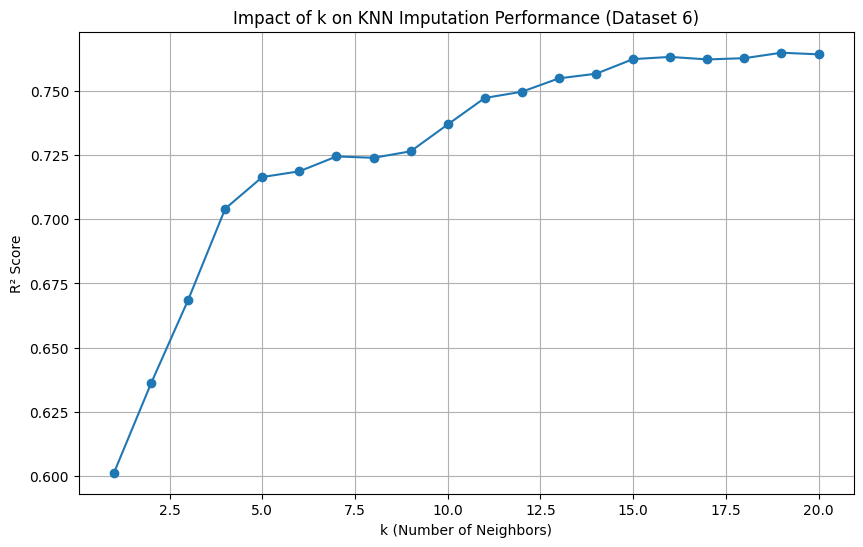

In [104]:
analyze_k_impact("dataset", dataset_num=6)

**Explanation:**